## Q8 MNIST with Transfer Learning

In [1]:
#Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data Visualizations
import matplotlib.pyplot as plt
# !pip install seaborn
import os
import cv2
import numpy as np
import seaborn as sns
import struct
from tqdm import tqdm
from random import shuffle
import pandas as pd

In [2]:
with open('train-images-idx3-ubyte/train-images.idx3-ubyte', 'rb') as f:
    magic, size = struct.unpack('>II', f.read(8))
    nrows, ncols = struct.unpack('>II', f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8)).newbyteorder(">")
    data = data.reshape((size,nrows,ncols))
with open('train-labels-idx1-ubyte/train-labels.idx1-ubyte', 'rb') as i:
    magic, size = struct.unpack('>II', i.read(8))
    data_1 = np.fromfile(i, dtype=np.dtype(np.uint8)).newbyteorder(">") 
    
data_train, labels_train = data, data_1

5

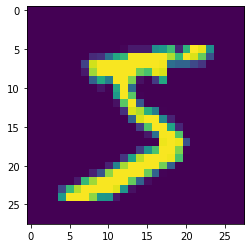

In [3]:
plt.imshow(data_train[0])
labels_train[0]

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_train,labels_train,random_state=5,stratify=labels_train,test_size=0.3)

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def change_size(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = img.resize((75, 75)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float64)

In [6]:
train_arr = np.array(X_train).reshape(-1, 28, 28, 1)
train_arr.shape

(42000, 28, 28, 1)

In [7]:
train_arr_75 = [change_size(img) for img in tqdm(train_arr)]
del train_arr
train_arr_75 = np.array(train_arr_75)
train_arr_75.shape

100%|██████████████████████████████████████████████████████████████████████████| 42000/42000 [00:10<00:00, 3825.42it/s]


(42000, 75, 75, 3)

In [8]:
test_arr = np.array(X_test).reshape(-1, 28, 28, 1)
test_arr.shape

(18000, 28, 28, 1)

In [9]:
test_arr_75 = [change_size(img) for img in tqdm(test_arr)]
del test_arr
test_arr_75 = np.array(test_arr_75)
test_arr_75.shape

100%|██████████████████████████████████████████████████████████████████████████| 18000/18000 [00:04<00:00, 3909.40it/s]


(18000, 75, 75, 3)

In [10]:
y_train = tf.keras.utils.to_categorical(y_train)
y_testc = tf.keras.utils.to_categorical(y_test)
image_gen = ImageDataGenerator(rescale=1./255, #easier for network to interpret numbers in range [0,1]
                              zoom_range=0.1,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              validation_split=0.2) # 80/20 train/val split

train_generator = image_gen.flow(train_arr_75, 
                                 y_train,
                                batch_size=32,
                                shuffle=True,
                                subset='training',
                                seed=42)
valid_generator = image_gen.flow(train_arr_75,
                                 y_train,
                                batch_size=16,
                                shuffle=True,
                                subset='validation')
test_generator = image_gen.flow(test_arr_75, 
                                 y_testc,
                                batch_size=32,
                                seed=42,shuffle=False)
del train_arr_75 #saves RAM

<AxesSubplot:>

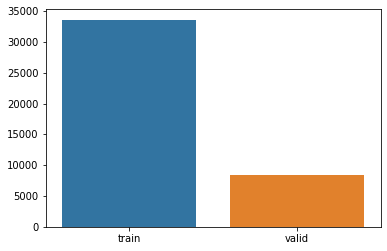

In [11]:
sns.barplot(x = ['train', 'valid'], y= [train_generator.n, valid_generator.n])

In [12]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet')
# base_model.trainable = False
model = Sequential()

model.add(base_model)

model.add(L.Flatten())
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#Do not use default learning rate since it is too high!

In [13]:
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block1_0_conv':
        break
    layer.trainable=False

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 28,340,746
Trainable params: 16,842,378
Non-trainable params: 11,498,368
_________________________________________________________________


In [15]:
epochs = 5
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, 
          steps_per_epoch=train_generator.n//train_generator.batch_size,
         validation_steps=valid_generator.n//valid_generator.batch_size)

Epoch 1/5
1050/1050 [==============================] - 139s 120ms/step - loss: 0.1840 - accuracy: 0.9461 - val_loss: 0.2477 - val_accuracy: 0.9173
Epoch 2/5
1050/1050 [==============================] - 126s 119ms/step - loss: 0.0699 - accuracy: 0.9811 - val_loss: 0.0658 - val_accuracy: 0.9830
Epoch 3/5
1050/1050 [==============================] - 126s 120ms/step - loss: 0.0560 - accuracy: 0.9845 - val_loss: 0.0804 - val_accuracy: 0.9800
Epoch 4/5
1050/1050 [==============================] - 126s 120ms/step - loss: 0.0536 - accuracy: 0.9854 - val_loss: 0.0428 - val_accuracy: 0.9892
Epoch 5/5
1050/1050 [==============================] - 126s 120ms/step - loss: 0.0438 - accuracy: 0.9878 - val_loss: 0.0885 - val_accuracy: 0.9775


In [16]:
pred = model.predict(test_generator)
predictions = np.argmax(pred,axis = 1)

In [17]:
tf.math.confusion_matrix(y_test,predictions)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1763,    0,    2,    1,    0,    0,    5,    2,    2,    2],
       [   0, 2020,    0,    0,    0,    0,    0,    3,    0,    0],
       [   0,   10, 1726,   17,    0,    0,    0,   33,    1,    0],
       [   0,    0,    0, 1831,    0,    2,    0,    6,    0,    0],
       [   0,   26,    0,    0, 1655,    0,    4,   52,    0,   16],
       [   0,    0,    0,   14,    0, 1601,    5,    3,    1,    2],
       [   5,    2,    3,    0,    0,    3, 1762,    0,    0,    0],
       [   0,    9,    1,    1,    0,    0,    0, 1869,    0,    0],
       [   0,    5,    1,   37,    4,    7,    8,    6, 1674,   13],
       [   1,    7,    0,   21,    4,    2,    0,   47,    2, 1701]])>

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1777
           1       0.97      1.00      0.98      2023
           2       1.00      0.97      0.98      1787
           3       0.95      1.00      0.97      1839
           4       1.00      0.94      0.97      1753
           5       0.99      0.98      0.99      1626
           6       0.99      0.99      0.99      1775
           7       0.92      0.99      0.96      1880
           8       1.00      0.95      0.97      1755
           9       0.98      0.95      0.97      1785

    accuracy                           0.98     18000
   macro avg       0.98      0.98      0.98     18000
weighted avg       0.98      0.98      0.98     18000



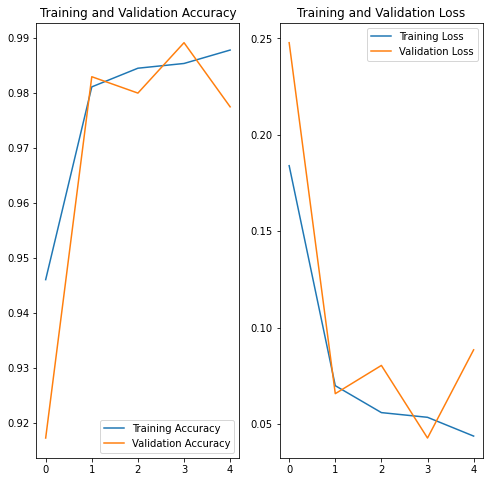

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = epochs
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## Building a CNN from Scratch

In [20]:
# num_classes = 10

model2 = Sequential(
    [
        layers.InputLayer((75,75,3)),

        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        
        
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(10,activation='softmax'),
    ]
)


model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)         

In [22]:
epochs2 = 10
history = model2.fit(train_generator, validation_data=valid_generator, epochs=epochs2, 
          steps_per_epoch=train_generator.n//train_generator.batch_size,
         validation_steps=valid_generator.n//valid_generator.batch_size)

Epoch 1/10
1050/1050 [==============================] - 51s 47ms/step - loss: 0.7384 - accuracy: 0.7547 - val_loss: 0.3290 - val_accuracy: 0.8976
Epoch 2/10
1050/1050 [==============================] - 49s 47ms/step - loss: 0.2546 - accuracy: 0.9204 - val_loss: 0.2190 - val_accuracy: 0.9352
Epoch 3/10
1050/1050 [==============================] - 50s 48ms/step - loss: 0.1895 - accuracy: 0.9411 - val_loss: 0.1824 - val_accuracy: 0.9445
Epoch 4/10
1050/1050 [==============================] - 50s 47ms/step - loss: 0.1559 - accuracy: 0.9513 - val_loss: 0.1453 - val_accuracy: 0.9543
Epoch 5/10
1050/1050 [==============================] - 50s 47ms/step - loss: 0.1277 - accuracy: 0.9601 - val_loss: 0.1311 - val_accuracy: 0.9585
Epoch 6/10
1050/1050 [==============================] - 49s 47ms/step - loss: 0.1211 - accuracy: 0.9623 - val_loss: 0.1157 - val_accuracy: 0.9651
Epoch 7/10
1050/1050 [==============================] - 50s 47ms/step - loss: 0.1050 - accuracy: 0.9669 - val_loss: 0.1045 -

In [23]:
pred = model2.predict(test_generator)
predictions = np.argmax(pred,axis = 1)

In [24]:
tf.math.confusion_matrix(y_test,predictions)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1741,    1,    2,    0,    1,    4,   15,    3,    6,    4],
       [   1, 2003,    0,    2,    9,    1,    1,    5,    1,    0],
       [   5,   15, 1698,   15,    9,    3,    1,   23,   15,    3],
       [   1,    2,   13, 1792,    0,   16,    0,    4,    7,    4],
       [   1,    2,    0,    0, 1727,    1,    4,    2,    1,   15],
       [   1,    0,    1,    4,    2, 1596,   11,    0,    7,    4],
       [   2,    3,    1,    0,    4,   11, 1752,    0,    2,    0],
       [   0,    4,    5,    6,    9,    3,    0, 1842,    1,   10],
       [   8,    3,    3,    5,    7,   15,   16,    2, 1672,   24],
       [   4,    3,    2,    6,   25,   13,    0,   13,    3, 1716]])>

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1777
           1       0.98      0.99      0.99      2023
           2       0.98      0.95      0.97      1787
           3       0.98      0.97      0.98      1839
           4       0.96      0.99      0.97      1753
           5       0.96      0.98      0.97      1626
           6       0.97      0.99      0.98      1775
           7       0.97      0.98      0.98      1880
           8       0.97      0.95      0.96      1755
           9       0.96      0.96      0.96      1785

    accuracy                           0.97     18000
   macro avg       0.97      0.97      0.97     18000
weighted avg       0.97      0.97      0.97     18000



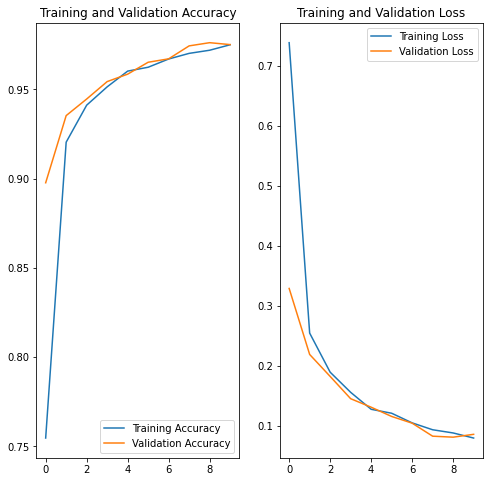

In [26]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = epochs2
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

From the data we can see that the CNN based Classifiers perform much better compared to the SVM classifier. This is the result of using complex interlinked neuralnets which in theory can approximate any function perfectly(Universal approximation Theorem).

In [27]:
model2.save('model2.h5')

In [28]:
model2.save_weights('model2_weights.h5')

## Q3 Training SVM on CNN Features

In [2]:
# path ="archive (1)/real_and_f#renaming real and fake directories
real = "archive/real_and_fake_face_detection/real_and_fake_face/training_real"
fake = "archive/real_and_fake_face_detection/real_and_fake_face/training_fake"
#we're creating a list of real and fake images
real_path = os.listdir(real)
fake_path = os.listdir(fake)


In [3]:
img_size = int(75)
def create_data():
    training_data = []
    y=[]
    for img in tqdm(real_path):
        path = os.path.join(real, img)
#         label = [1] 
        try:
            image = cv2.resize( cv2.imread(path), (img_size,img_size) )
            training_data.append(np.array(image))
            y.append(1)
        except:
            continue
        
    for img in tqdm(fake_path):
        path = os.path.join(fake, img)
#         label = [0] 
        try:
            image = cv2.resize(cv2.imread(path), (img_size,img_size))
            training_data.append(np.array(image))  
            y.append(0)
        except: continue
        
    return(training_data,y)


    

data,labels = create_data()


100%|███████████████████████████████████████████████████████████████████████████████| 961/961 [00:07<00:00, 127.58it/s]


In [4]:
data = np.array(data)
labels = np.array(labels)

In [5]:
len(data)

2041

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,labels,random_state=6,test_size=0.3,stratify=labels)

In [7]:
y_trainn = tf.keras.utils.to_categorical(y_train)
y_testc = tf.keras.utils.to_categorical(y_test)
image_gen = ImageDataGenerator(rescale=1./255, #easier for network to interpret numbers in range [0,1]
                              zoom_range=0.1,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              validation_split=0.2) # 80/20 train/val split



In [8]:
X_train.shape,y_trainn.shape

((1428, 75, 75, 3), (1428, 2))

In [9]:
# num_classes = 10

model3 = Sequential(
    [
        layers.InputLayer((75,75,3)),

        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        
        
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(1024, activation="relu"),
        layers.Dense(2,activation='softmax'),
    ]
)


model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])


In [10]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 64)          0

In [11]:
history = model3.fit(X_train,y_trainn,epochs = 100,verbose = 1,validation_split=0.1)

Epoch 1/100
41/41 [==============================] - 4s 23ms/step - loss: 0.9631 - accuracy: 0.5136 - val_loss: 0.7491 - val_accuracy: 0.4685
Epoch 2/100
41/41 [==============================] - 0s 9ms/step - loss: 0.7341 - accuracy: 0.5315 - val_loss: 0.7215 - val_accuracy: 0.4476
Epoch 3/100
41/41 [==============================] - 0s 9ms/step - loss: 0.7110 - accuracy: 0.5268 - val_loss: 0.6981 - val_accuracy: 0.5245
Epoch 4/100
41/41 [==============================] - 0s 9ms/step - loss: 0.7104 - accuracy: 0.5268 - val_loss: 0.7078 - val_accuracy: 0.5245
Epoch 5/100
41/41 [==============================] - 0s 9ms/step - loss: 0.7047 - accuracy: 0.5198 - val_loss: 0.7227 - val_accuracy: 0.4545
Epoch 6/100
41/41 [==============================] - 0s 9ms/step - loss: 0.7006 - accuracy: 0.5113 - val_loss: 0.6914 - val_accuracy: 0.5315
Epoch 7/100
41/41 [==============================] - 0s 9ms/step - loss: 0.6889 - accuracy: 0.5549 - val_loss: 0.7050 - val_accuracy: 0.4545
Epoch 8/100


In [12]:
# Taking the CNN outputs and feeding to SVM
model_feat = Model(inputs=model3.input,outputs=model3.get_layer('dense_3').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

(1428, 1024)
(613, 1024)


In [13]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_trainn,axis=1))

print('Training on SVM complete')

Training on SVM complete


In [14]:
svm.score(feat_train,np.argmax(y_trainn,axis=1))

0.9642857142857143

In [15]:
predictions = svm.predict(feat_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.56      0.59      0.57       288
           1       0.62      0.60      0.61       325

    accuracy                           0.59       613
   macro avg       0.59      0.59      0.59       613
weighted avg       0.59      0.59      0.59       613



In [16]:
model3.save('model3.h5')
model3.save_weights('model3_weights.h5')